In [164]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC

This code shamelessly stolen from https://matplotlib.org/3.2.2/gallery/animation/double_pendulum_sgskip.html

In [165]:

def diffyqs(state, t,G, L1, L2, M1, M2):

    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    delta = state[2] - state[0]
    den1 = (M1+M2) * L1 - M2 * L1 * np.cos(delta) * np.cos(delta)
    dydx[1] = ((M2 * L1 * state[1] * state[1] * np.sin(delta) * np.cos(delta)
                + M2 * G * np.sin(state[2]) * np.cos(delta)
                + M2 * L2 * state[3] * state[3] * np.sin(delta)
                - (M1+M2) * G * np.sin(state[0]))
               / den1)

    dydx[2] = state[3]

    den2 = (L2/L1) * den1
    dydx[3] = ((- M2 * L2 * state[3] * state[3] * np.sin(delta) * np.cos(delta)
                + (M1+M2) * G * np.sin(state[0]) * np.cos(delta)
                - (M1+M2) * L1 * state[1] * state[1] * np.sin(delta)
                - (M1+M2) * G * np.sin(state[2]))
               / den2)

    return dydx


# initial condition
th1 = 120.0
w1 = 0.0
th2 = -10.0
w2 = 0.0
initial_condition = np.radians([th1, w1, th2, w2])

# parameters
G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 1.0  # mass of pendulum 2 in kg

# time setup
dt = 0.05
t = np.arange(0, 10, dt)


#integrate
y = odeint(diffyqs, initial_condition, t, args = (G,L1,L2,M1,M2))

In [166]:
x1 = L1*np.sin(y[:, 0])
y1 = -L1*np.cos(y[:, 0])

x2 = L2*np.sin(y[:, 2]) + x1
y2 = -L2*np.cos(y[:, 2]) + y1

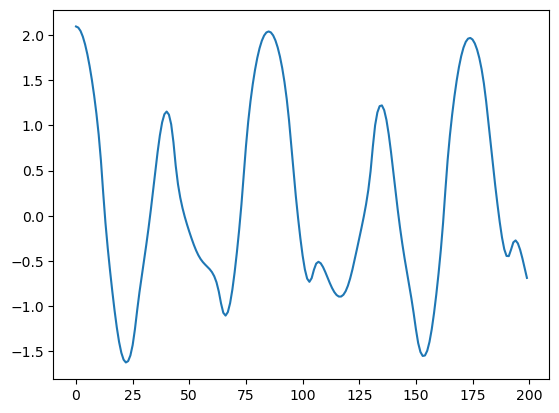

In [167]:
plt.plot(y[:, 0])

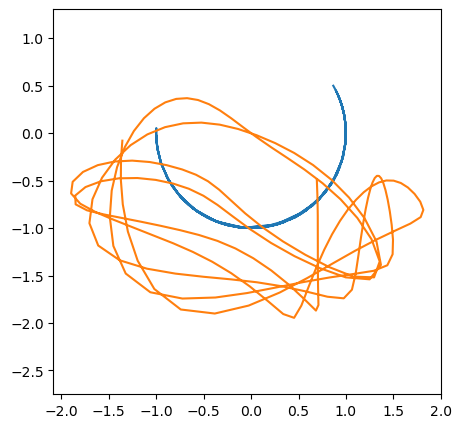

In [168]:
plt.figure(figsize=(5,5))
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.axis('equal')
plt.show()

In [169]:
def log_likelihood(theta):
    G = theta # unpack parameters from theta

    sol = odeint(diffyqs, initial_condition, t, args = (G,L1,L2,M1,M2)) # get solution of ODE with current choice of params
    
    return -np.sum((sol[:, 0] - y[:, 0])**2 + (sol[:, 2] - y[:, 2])**2) # normal distribution

In [170]:
D = 1  

prior_mu =  np.full((1,D), 10.0) # 
prior_std = 5 * np.ones((1, D)) # std of the prior

LB = np.full((1, D), 0.0)  # Lower bounds (we know from the model that they have to be positive, negative values would break odeint)
UB = np.full((1, D), 2000.0)  # Upper bounds (picked to be reasonable)

PLB =  scs.norm.ppf(0.1587, prior_mu, prior_std)
PUB =  scs.norm.ppf(0.8413, prior_mu, prior_std)

x0 = np.copy(prior_mu) # starting point for inference   # 1.5 * np.ones((1, D))

options = {
    "max_fun_evals": 300
}

vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = [scs.norm(loc = 10)], options = options) # initialize VMBC object

In [171]:
vp, results = vbmc.optimize();

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10         -18.56        29.01 809619647.10        2        inf     start warm-up
     1         15          -3.41         0.02         9.56        2        inf     
     2         20          -3.43         0.00         0.00        2     0.0714     
     3         25          -3.43         0.00         0.00        2     0.0293     
     4         30          -3.44         0.00         0.00        2     0.0497     
     5         35          -3.45         0.00         0.00        2        0.2     
     6         40          -3.44         0.00         0.00        2      0.058     end warm-up
     7         45          -3.44         0.00         0.01        2      0.323     
     8         50          -3.43         0.00         0.01        2      0.365     
     9         55          -3.44         0.00    

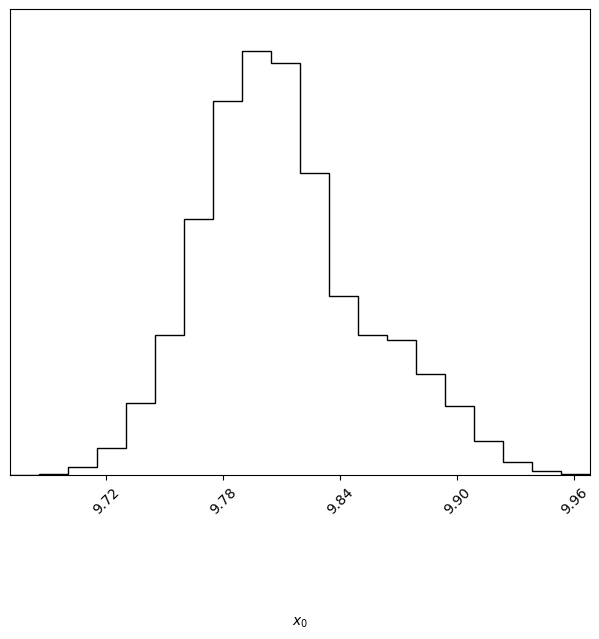

In [172]:
vp.plot();

In [173]:
# First, generate a large number of samples from the variational posterior:
n_samples = int(5e5)
Xs, _ = vp.sample(n_samples)

# Easily compute statistics such as moments, credible intervals, etc.
post_mean = np.mean(Xs, axis=0)  # Posterior mean
post_cov = np.cov(Xs.T)  # Posterior covariance matrix
print("The approximate posterior mean is:", post_mean)
#print("The approximate posterior covariance matrix is:\n", post_cov)

The approximate posterior mean is: [9.81047481]


This works really well!!

however, increasing the time interval makes it converge not as well

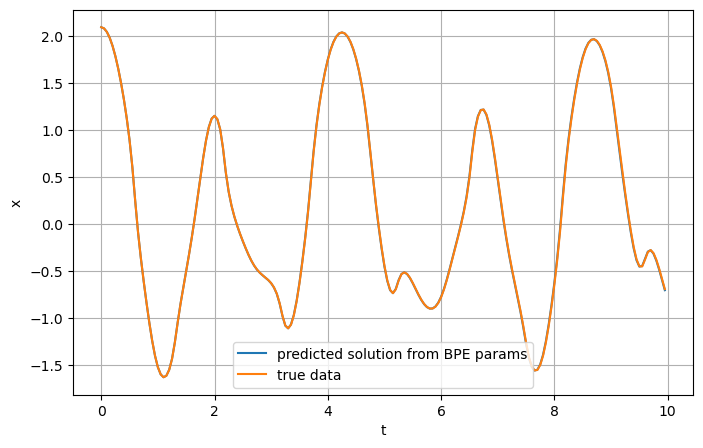

In [174]:
G =  post_mean[0]

sol = odeint(diffyqs, initial_condition, t, args = (G,L1,L2,M1,M2))

plt.figure(figsize=(8,5))
#plt.title("Solution from Uniform Box Prior")
plt.plot(t,sol[:, 0], label = "predicted solution from BPE params")
plt.plot(t,y[:, 0], label = "true data")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

In [175]:
# initial condition
th1 = 120.0
w1 = 0.0
th2 = -10.0
w2 = 0.0
initial_condition = np.radians([th1, w1, th2, w2])

# parameters
G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 1.0  # mass of pendulum 2 in kg

# time setup
dt = 0.05
t = np.arange(0, 10, dt)

#integrate
y = odeint(diffyqs, initial_condition, t, args = (G,L1,L2,M1,M2))

def log_likelihood(theta):
    L1,L2 = theta # unpack parameters from theta

    sol = odeint(diffyqs, initial_condition, t, args = (G,L1,L2,M1,M2)) # get solution of ODE with current choice of params
    
    return -np.sum((sol[:, 0] - y[:, 0])**2 + (sol[:, 2] - y[:, 2])**2) # normal distribution

In [176]:
D = 2  

prior_mu =  np.full((1,D), 10.0) # 
prior_std = 5 * np.ones((1, D)) # std of the prior

LB = np.full((1, D), 0.0)  # Lower bounds (we know from the model that they have to be positive, negative values would break odeint)
UB = np.full((1, D), 2000.0)  # Upper bounds (picked to be reasonable)

PLB =  scs.norm.ppf(0.1587, prior_mu, prior_std)
PUB =  scs.norm.ppf(0.8413, prior_mu, prior_std)

x0 = np.copy(prior_mu) # starting point for inference   # 1.5 * np.ones((1, D))

options = {
    "max_fun_evals": 300
}

vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = UniformBox(LB,UB), options = options) # initialize VMBC object

In [177]:
vp, results = vbmc.optimize();

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10       -3407.30      1011.52 341897627.47        2        inf     start warm-up
     1         15       -3440.21        43.39        25.79        2        inf     


KeyboardInterrupt: 

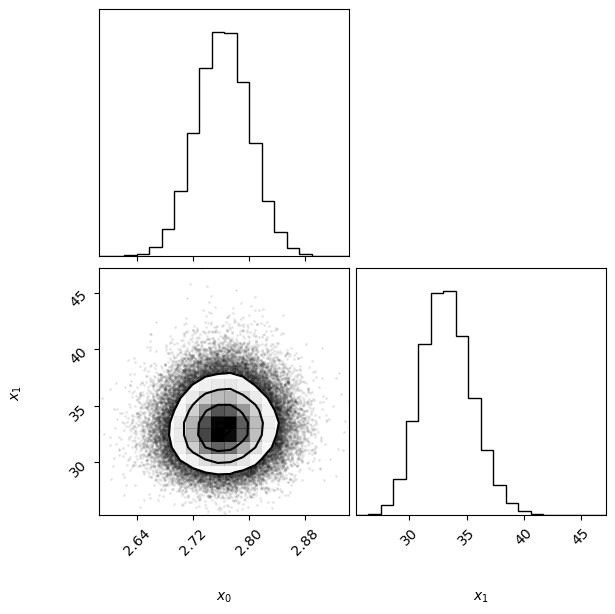

In [ ]:
vp.plot();

In [ ]:
# First, generate a large number of samples from the variational posterior:
n_samples = int(5e5)
Xs, _ = vp.sample(n_samples)

# Easily compute statistics such as moments, credible intervals, etc.
post_mean = np.mean(Xs, axis=0)  # Posterior mean
post_cov = np.cov(Xs.T)  # Posterior covariance matrix
print("The approximate posterior mean is:", post_mean)
#print("The approximate posterior covariance matrix is:\n", post_cov)

The approximate posterior mean is: [ 2.76330059 33.30369405]


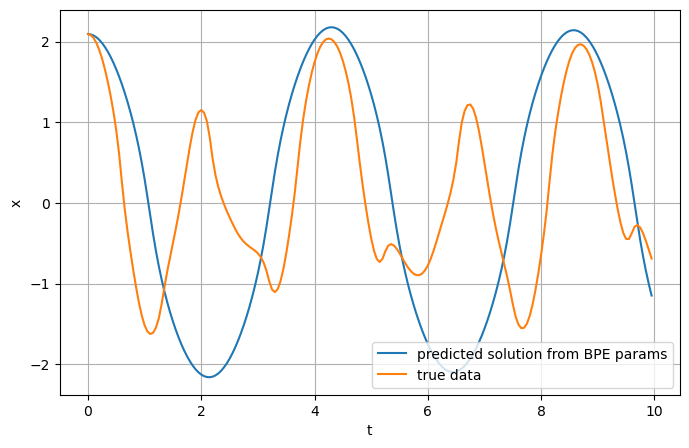

In [ ]:
L1 =  post_mean[0]
L2 = post_mean[1]

sol = odeint(diffyqs, initial_condition, t, args = (G,L1,L2,M1,M2))

plt.figure(figsize=(8,5))
#plt.title("Solution from Uniform Box Prior")
plt.plot(t,sol[:, 0], label = "predicted solution from BPE params")
plt.plot(t,y[:, 0], label = "true data")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

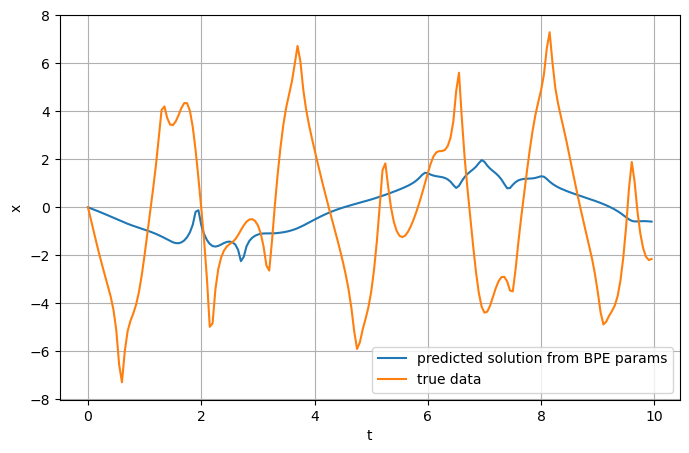

In [ ]:
plt.figure(figsize=(8,5))
#plt.title("Solution from Uniform Box Prior")
plt.plot(t,sol[:, 1], label = "predicted solution from BPE params")
plt.plot(t,y[:, 1], label = "true data")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

In [ ]:
def log_likelihood(theta):
    G, L1, L2, M1, M2 = theta # unpack parameters from theta

    sol = odeint(diffyqs, initial_condition, t, args = (G,L1,L2,M1,M2)) # get solution of ODE with current choice of params
    
    return -np.sum((sol[:, 2] - y[:, 2])**2) # normal distribution

D = 5  

prior_mu =  np.full((1,D), 3.0)
prior_std = 1 * np.ones((1, D)) # std of the prior

LB = np.full((1, D), 0.0)  # Lower bounds (we know from the model that they have to be positive, negative values would break odeint)
UB = np.full((1, D), 5.0)  # Upper bounds (picked to be reasonable)
UB[0][0] = 20

PLB =  np.full((1, D), 0.5) #scs.norm.ppf(0.1587, prior_mu, prior_std)
PUB =  np.full((1, D), 2.0) #scs.norm.ppf(0.8413, prior_mu, prior_std)
PLB[0][0] = 8
PUB[0][0] = 11
x0 = np.copy(PLB) + 0.5 # starting point for inference   # 1.5 * np.ones((1, D))

options = {
    "max_fun_evals": 150
}

vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = [scs.norm(loc = 10),scs.norm(loc = 1),scs.norm(loc = 1),scs.norm(loc = 1),scs.norm(loc = 1)], options = options) # initialize VMBC object

In [ ]:
vp, results = vbmc.optimize();

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10        -679.97       876.85 77946955252.07        2        inf     start warm-up
     1         15          75.16       152.58       185.74        2        inf     
     2         20          79.91       404.16      1184.43        2    1.9e+04     
     3         25        3756.65      6204.18      9836.72        2    1.8e+05     
     4         30   284695779.12 721139146.35 43587716476109.55        2    6.5e+14     trim data
     5         35         135.93       826.09 80604929026204.47        2    1.2e+15     
     6         40        7242.36      4522.97     45427.20        2   7.16e+05     end warm-up
     7         45          48.30        92.47     56991.72        2   8.74e+05     
     8         50         341.38      1081.15      2384.35        2   4.01e+04     
     9         55        291

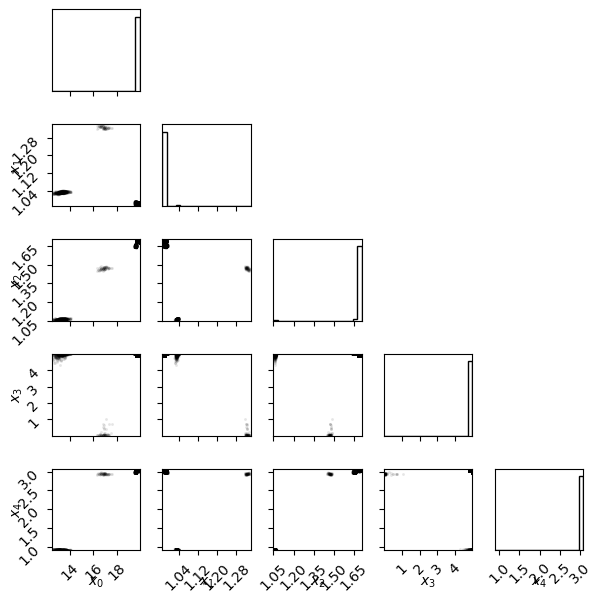

In [ ]:
vp.plot();

In [ ]:
# First, generate a large number of samples from the variational posterior:
n_samples = int(5e5)
Xs, _ = vp.sample(n_samples)

# Easily compute statistics such as moments, credible intervals, etc.
post_mean = np.mean(Xs, axis=0)  # Posterior mean
post_cov = np.cov(Xs.T)  # Posterior covariance matrix
print("The approximate posterior mean is:", post_mean)
#print("The approximate posterior covariance matrix is:\n", post_cov)

The approximate posterior mean is: [19.91846502  0.98187058  1.68430873  4.99635742  3.02052359]


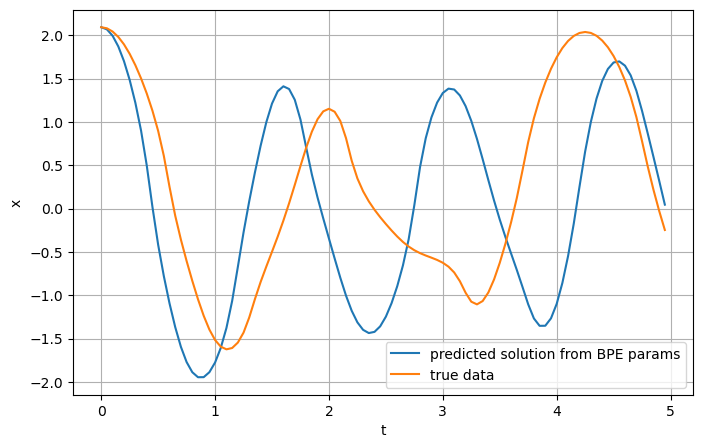

In [ ]:
G,L1,L2,M1,M2 =  [post_mean[i] for i in range(5)]

sol = odeint(diffyqs, initial_condition, t, args = (G,L1,L2,M1,M2))

plt.figure(figsize=(8,5))
#plt.title("Solution from Uniform Box Prior")
plt.plot(t,sol[:, 0], label = "predicted solution from BPE params")
plt.plot(t,y[:, 0], label = "true data")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()